In [1]:
import numpy as np
from randomforest import RandomForest
from decisiontree import DecisionTree
from matplotlib import pyplot as plt
import matplotlib

In [8]:
def calculate_f1(y, yhat):
    tp = np.sum((y == 1) & (yhat == 1))
    fp = np.sum((y == 0) & (yhat == 1))
    fn = np.sum((y == 1) & (yhat == 0))
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    return 2*recall*precision/(recall+precision)
    
def calculate_acc(y, yhat):
    return np.sum(y==yhat)/len(y)

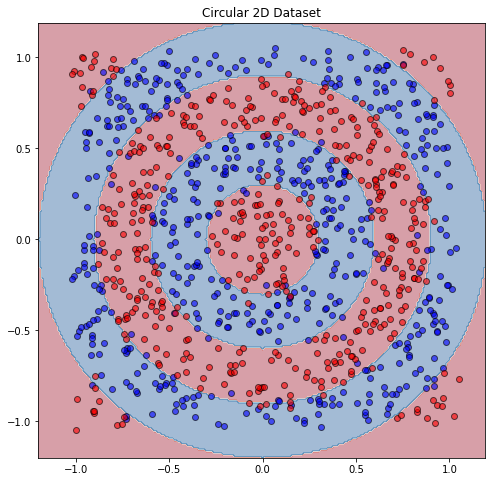

In [3]:
# test on specific shapes
np.random.seed(99)
X = np.random.uniform(size=(1000,2))*2-1

# generate meshgrid for future plotting
h = 0.01
x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
cm = plt.cm.RdBu

def colorshape(X):
    """Label points of 0, 1."""
    x, y = X[:,0], X[:,1]
    return ((x**2+y**2 > 0.3**2) & (x**2+y**2 < 0.6**2) \
            | (x**2+y**2 > 0.9**2) & (x**2+y**2 < 1.2**2))*1

# assign labels
y = colorshape(X) 
# add gaussian noise
X += (np.random.normal(scale = 0.03, size=(X.shape))) 
plt.figure(figsize = (8,8))
plt.contourf(xx,yy, colorshape(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape),
             cmap=cm, alpha = 0.4)
plt.scatter(X[y==1,0],X[y==1,1], c = 'b', alpha = 0.6,edgecolors='k')
plt.scatter(X[y==0,0],X[y==0,1], c = 'r', alpha = 0.6,edgecolors='k')
plt.title('Circular 2D Dataset')
plt.savefig('data/originaldata')
plt.show()

In [4]:
# split data set
def split_data(X, y):
    """Split data into training and testing(validation)"""
    n,d = X.shape
    shuffled = np.arange(n)
    np.random.shuffle(shuffled)
    train_n = int(n*0.8)
    test_n = n-train_n
    train_idx = shuffled[:train_n]
    test_idx = shuffled[train_n:]
    return X[train_idx,], y[train_idx], X[test_idx,], y[test_idx]

X_train, y_train, X_test, y_test = split_data(X, y)

In [9]:
from sklearn.ensemble import RandomForestClassifier
# run forest and decision tree over different max depth
np.random.seed(99)
tree_train = []
tree_test = []
forest_train = []
forest_test = []
sk_train = []
sk_test = []
depths = np.arange(2,30)
func = calculate_f1 # plot f1 score

for depth in depths:
    tree = DecisionTree(depth)
    tree.fit(X_train, y_train)
    tree_train.append(func(y_train, tree.predict(X_train)))
    tree_test.append(func(y_test, tree.predict(X_test)))
    
    forest = RandomForest(feature_count=2, tree_num = 10, depth = depth)
    forest.fit(X_train, y_train)
    forest_train.append(func(y_train, forest.predict(X_train)))
    forest_test.append(func(y_test, forest.predict(X_test)))
    
    clf = RandomForestClassifier(n_estimators=10, max_depth=depth)
    clf.fit(X_train, y_train)
    sk_train.append(func(y_train, clf.predict(X_train)))
    sk_test.append(func(y_test, clf.predict(X_test)))


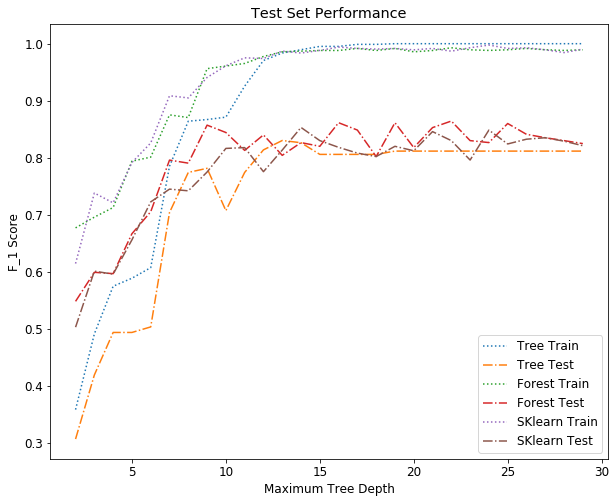

In [10]:
plt.figure(figsize = (10,8))
matplotlib.rcParams.update({'font.size': 12})
plt.plot(depths,tree_train, ls = ':', label = 'Tree Train')
plt.plot(depths,tree_test, ls = '-.', label = 'Tree Test')
plt.plot(depths,forest_train, ls = ':', label = 'Forest Train')
plt.plot(depths,forest_test, ls = '-.', label = 'Forest Test')
plt.plot(depths,sk_train, ls = ':', label = 'SKlearn Train')
plt.plot(depths,sk_test, ls = '-.', label = 'SKlearn Test')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('F_1 Score')
plt.title('Test Set Performance')
plt.legend()
plt.savefig('data/F1_compare')
plt.show()

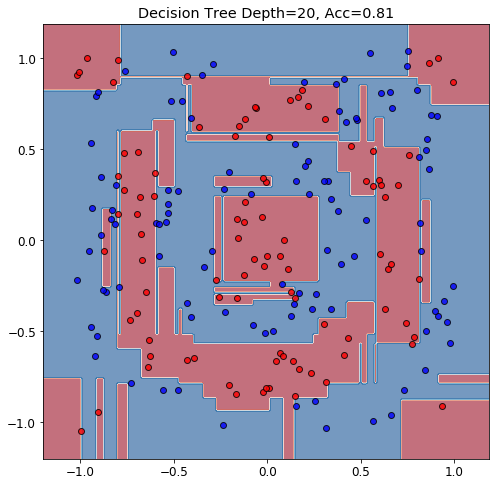

In [11]:
depth = 20
tree = DecisionTree(depth)
tree.fit(X_train, y_train)

plt.figure(figsize=(8,8))
plt.contourf(xx,yy, tree.predict_prob(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape),cmap=cm, alpha = 0.6)
y_pred = tree.predict(X_test)
plt.scatter(X_test[y_pred==1,0],X_test[y_pred==1,1], c= 'b', alpha = .8,edgecolors='k')
plt.scatter(X_test[y_pred==0,0],X_test[y_pred==0,1], c= 'r', alpha = .8,edgecolors='k')
plt.title('Decision Tree Depth={:d}, Acc={:3.2f}'.format(depth, calculate_acc(y_test, y_pred)))
plt.savefig('data/tree_20')
plt.show()
# print(tree) # visualize tree

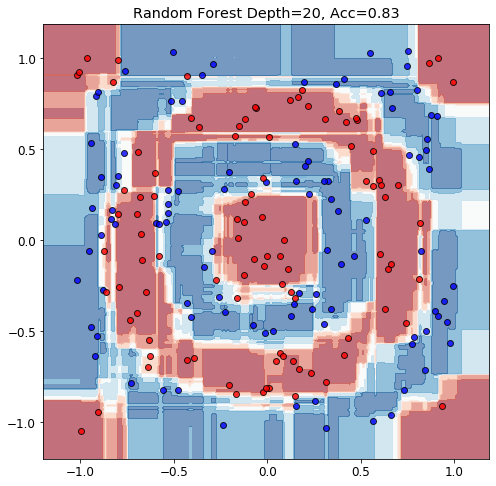

In [12]:
depth = 20
forest = RandomForest(feature_count=2,tree_num=20, depth=depth)
forest.fit(X_train, y_train)

plt.figure(figsize=(8,8))
plt.contourf(xx,yy, forest.predict_prob(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape),cmap=cm, alpha = 0.6)
y_pred = forest.predict(X_test)
plt.scatter(X_test[y_pred==1,0],X_test[y_pred==1,1], c= 'b', alpha = .8,edgecolors='k')
plt.scatter(X_test[y_pred==0,0],X_test[y_pred==0,1], c= 'r', alpha = .8,edgecolors='k')
plt.title('Random Forest Depth={:d}, Acc={:3.2f}'.format(depth, calculate_acc(y_test, y_pred)))
plt.savefig('data/forest_20')
plt.show()